In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

## Регионы

In [28]:
gdf = gpd.read_file("data/russia_regions.geojson")
gdf.info()            
gdf.sample(4)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   region            85 non-null     object  
 1   federal_district  85 non-null     object  
 2   population        85 non-null     int64   
 3   geometry          85 non-null     geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 2.8+ KB


region federal_district  population  \
16  Республика Башкортостан      Приволжский     4077600   
52      Кемеровская область        Сибирский     2568238   
30     Чувашская Республика      Приволжский     1173177   
37      Ульяновская область      Приволжский     1181006   

                                             geometry  
16  MULTIPOLYGON (((53.15754 55.13295, 53.15906 55...  
52  MULTIPOLYGON (((84.45382 56.04315, 84.45462 56...  
30  MULTIPOLYGON (((48.05063 54.98909, 48.05080 54...  
37  MULTIPOLYGON (((45.79665 53.98576, 45.79742 53...

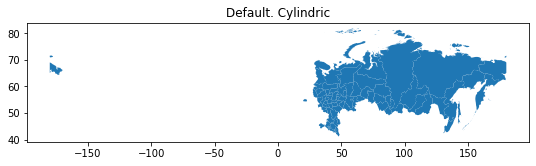

In [16]:
gdf.plot(figsize=(9,6))
plt.title('Default. Cylindric');

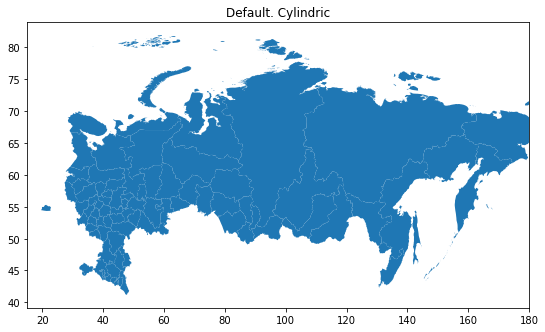

In [15]:
gdf.plot(figsize=(9,6))
plt.xlim(15,180), plt.title('Default. Cylindric');

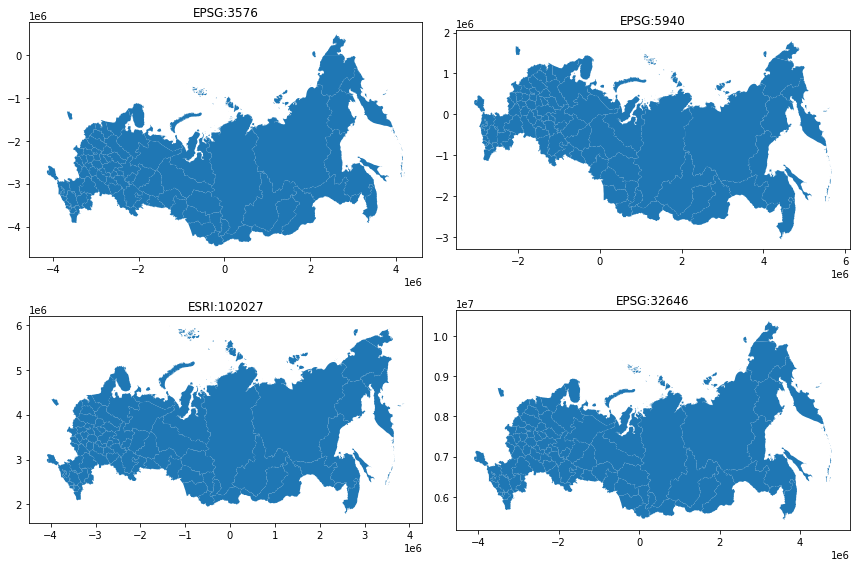

In [17]:
crss = ['EPSG:3576', 'EPSG:5940', 'ESRI:102027', 'EPSG:32646']
fig = plt.figure(figsize=(12,8))
for i, crs in enumerate(crss):
    ax = fig.add_subplot(2, 2, i+1)
    gdf.to_crs(crs).plot(ax=ax)
    ax.set_title(crs)
plt.tight_layout()
plt.show()

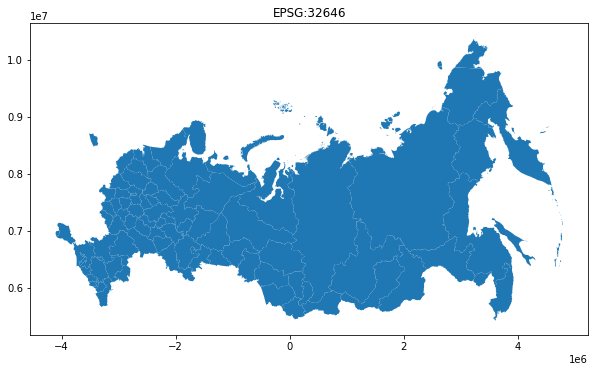

In [29]:
crs = 'EPSG:32646' # Pulkovo 95 CRS
gdf = gdf.to_crs(crs)
gdf.plot(figsize=(10,6))
plt.title(crs), plt.show();

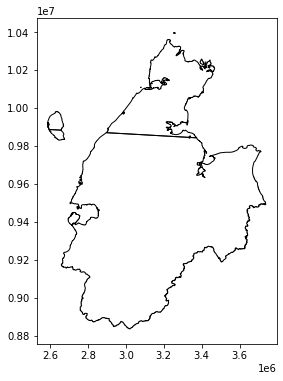

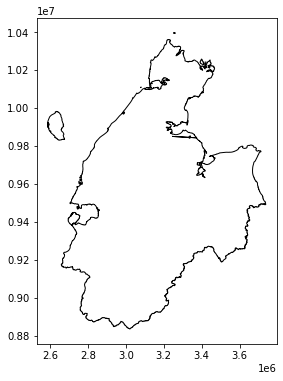

In [34]:
CHUK = 'Чукотский автономный округ'

gdf.loc[gdf.region == CHUK].plot(figsize=(6,6), facecolor="none")
plt.show()

# Объединение разбитых полигонов Чукотки
new_chuk = []
chuk_geoms = gdf.loc[gdf.region == CHUK, 'geometry'].values[0].geoms

# приклеим друг к другу полигоны находящиеся на расстоянии менее 100 единиц
for i, g in enumerate(chuk_geoms):
    new_g = g
    for j in range(len(chuk_geoms)):
        new_g = snap(new_g, chuk_geoms[j], 100)
    new_chuk.append(new_g)
new_chuk = unary_union(MultiPolygon(new_chuk))
gdf.loc[gdf.region == CHUK, 'geometry'] = new_chuk

gdf.loc[gdf.region == CHUK].plot(figsize=(6,6), facecolor="none")
plt.show();

Точек 3740


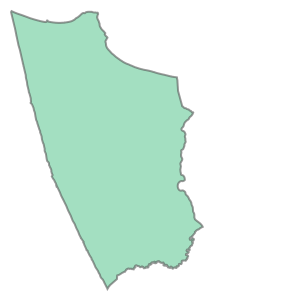

Точек 123


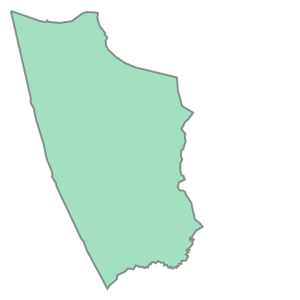

In [40]:
i = 61 # Калининградская область
tol = 500
print(f"Точек {shapely.get_num_coordinates(gdf.geometry[i])}") 
display(gdf.geometry[i])
print(f'Точек {shapely.get_num_coordinates(gdf.geometry[i].simplify(tol))}') 
display(gdf.geometry[i].simplify(tol))

In [41]:
from tqdm import tqdm

def prepare_regions(gdf, area_thr=100e6, simplify_tol=500):
    """Подготовка регионов к построению
    
    - Упрощение геометрии с допуском simplify_tol
    - Удаление полигонов с пощадью менее area_thr
    """
    gdf_ = gdf.copy()
    
    # Вспомогательный столбец для упорядочивания регионов по площади
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)

    # Удаляем маленькие полигоны
    tqdm.pandas(desc='Удаление мелких полигонов')
    gdf_.geometry = gdf_.geometry.progress_apply(lambda geometry: 
        MultiPolygon([p for p in geometry.geoms if p.area > area_thr]) 
            if type(geometry) == MultiPolygon else geometry
    )
    
    # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(simplify_tol)
    
    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    # проходим по всем граничащим полигонам и объединяем границы
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms
    
    # сортировка по площади
    gdf_ = gdf_.sort_values(by='area', ascending=False).reset_index(drop=True) 
    
    return gdf_.drop(columns=['area'])

In [42]:
def geom2shape(g):
    """Преобразование полигонов и мультиполигонов в plotly-readable шэйпы    
    
    Получает на вход Polygon или MultiPolygon из geopandas, 
    возвращает pd.Series с координатами x и y
    """
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type(g) == MultiPolygon:
        x, y = np.array([[], []])
        for poly in g.geoms:
            x_, y_ = poly.exterior.coords.xy
            x, y = (np.append(x, x_), np.append(y, y_))
            x, y = (np.append(x, None), np.append(y, None))
        x, y = x[:-1], y[:-1]
    # Если полигон, то просто извлекаем координаты
    elif type(g) == Polygon:      
        x, y = np.array(g.exterior.coords.xy)
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
    return pd.Series([x,y])

In [43]:
regions = prepare_regions(gdf)
# Преобразование полигонов в шейпы   
regions[['x','y']] = regions.geometry.progress_apply(geom2shape)
regions.to_parquet('data/russia_regions.parquet')
regions.head()

Удаление мелких полигонов: 100%|██████████| 85/85 [00:00<00:00, 1315.35it/s]


region federal_district  population  \
0    Республика Саха (Якутия)  Дальневосточный      997565   
1           Красноярский край        Сибирский     2845545   
2            Хабаровский край  Дальневосточный     1284090   
3  Чукотский автономный округ  Дальневосточный       47840   
4           Иркутская область        Сибирский     2344360   

                                            geometry  \
0  MULTIPOLYGON (((1938283.445 8486895.498, 19405...   
1  MULTIPOLYGON (((33005.017 8131140.519, 35462.3...   
2  MULTIPOLYGON (((3260155.621 7013112.507, 32626...   
3  MULTIPOLYGON (((2741726.517 9584552.374, 27422...   
4  POLYGON ((672251.138 6019892.875, 673691.301 6...   

                                                   x  \
0  [1938283.445371548, 1940534.4765284657, 194097...   
1  [33005.017206937075, 35462.3772034038, 36374.3...   
2  [3260155.6214775788, 3262629.3414506745, 32634...   
3  [2741726.5174139286, 2742235.2573461686, 27438...   
4  [672251.1376689398, 673691.300765981, 673446.4...   

                                                   y  
0  [8486895.497995904, 8486501.334447775, 8485674...  
1  [8131140.519159272, 8129810.54575796, 8125543....  
2  [7013112.506960788, 7011116.731883681, 7011621...  
3  [9584552.374254184, 9584978.506388908, 9583772...  
4  [6019892.874562745, 6017792.204244802, 6015136...

## Города

In [12]:
gdf = gpd.read_file("data/russia_cities.geojson")
gdf.info()
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   city              250 non-null    object  
 1   population        250 non-null    int64   
 2   region            250 non-null    object  
 3   federal_district  250 non-null    object  
 4   geometry          250 non-null    geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 9.9+ KB


city  population                region      federal_district  \
0    Смоленск      325500    Смоленская область        Центральный ФО   
1       Керчь      151500       Республика Крым              Южный ФО   
2    Таганрог      248600    Ростовская область              Южный ФО   
3    Белгород      394100  Белгородская область        Центральный ФО   
4  Ставрополь      450700   Ставропольский край  Северо-Кавказский ФО   

                                            geometry  
0  POLYGON ((31.78833 54.78801, 31.78839 54.78796...  
1  POLYGON ((36.34957 45.26584, 36.34975 45.26528...  
2  POLYGON ((38.79298 47.23052, 38.79811 47.21715...  
3  POLYGON ((36.44467 50.59525, 36.44495 50.59341...  
4  POLYGON ((41.85438 45.00910, 41.87030 45.00971...

In [16]:
gdf = gpd.read_file("data/russia_town_and_city_borders_polygon.geojson")
gdf[gdf.city.duplicated(keep=False)]

city  population                               region  \
18       Воронеж     1058300                  Воронежская область   
20          Тула      475200                     Тульская область   
21          Тула      475200                     Тульская область   
23          Тула      475200                     Тульская область   
25          Тула      475200                     Тульская область   
..           ...         ...                                  ...   
235  Владикавказ      303600  Республика Северная Осетия – Алания   
236  Владикавказ      303600  Республика Северная Осетия – Алания   
243    Махачкала      603500                  Республика Дагестан   
244    Махачкала      603500                  Республика Дагестан   
247    Махачкала      603500                  Республика Дагестан   

         federal_district                                           geometry  
18         Центральный ФО  POLYGON ((39.01323 51.60446, 39.02922 51.60215...  
20         Центральный ФО  POLYGON ((37.54375 54.08069, 37.54620 54.07691...  
21         Центральный ФО  POLYGON ((37.52257 54.10502, 37.52331 54.10290...  
23         Центральный ФО  POLYGON ((37.59425 54.06868, 37.60741 54.06316...  
25         Центральный ФО  POLYGON ((37.49563 54.16565, 37.49662 54.16024...  
..                    ...                                                ...  
235  Северо-Кавказский ФО  POLYGON ((44.68579 42.96502, 44.68692 42.96422...  
236  Северо-Кавказский ФО  POLYGON ((44.60474 43.05479, 44.60757 43.05337...  
243  Северо-Кавказский ФО  POLYGON ((47.31740 43.04263, 47.31785 43.04168...  
244  Северо-Кавказский ФО  POLYGON ((47.55550 42.88914, 47.55577 42.88870...  
247  Северо-Кавказский ФО  POLYGON ((47.45433 43.04208, 47.46321 43.04332...  

[106 rows x 5 columns]

In [58]:
gdf = gdf.to_crs(crs)

In [59]:
def prepare_cities(gdf):
    """Подготовка городов к построению"""
    gdf_ = gdf.copy()
    
    # Вспомогательный столбец
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)
    
    # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(500)
    
    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms
    
    # Преобразование полигонов и мультиполигонов в plotly-readable шэйпы
    def geom2shape(g):
        if type(g) == MultiPolygon:
            x, y = np.array([[], []])
            for poly in g.geoms:
                x_, y_ = poly.exterior.coords.xy
                x, y = (np.append(x, x_), np.append(y, y_))
                x, y = (np.append(x, None), np.append(y, None))
            x = x[:len(x)-1]
            y = y[:len(y)-1]
        else:      
            x, y = np.array(g.exterior.coords.xy)
        return pd.Series([x,y])
    
    tqdm.pandas(desc='Преобразование полигонов в шейпы')
    gdf_[['x','y']] = gdf_.geometry.progress_apply(geom2shape)

    return gdf_.sort_index()

cities = prepare_cities(gdf)
cities = cities.sort_values(by='area', ascending=False).reset_index(drop=True) # сортировка по площади
display(cities.head())

Преобразование полигонов в шейпы: 100%|██████████| 250/250 [00:00<00:00, 7161.87it/s]


city  population                   region federal_district  \
0   Норильск      181800        Красноярский край     Сибирский ФО   
1  Волгоград     1009000    Волгоградская область         Южный ФО   
2      Пермь     1055400            Пермский край   Приволжский ФО   
3    Воронеж     1058300      Воронежская область   Центральный ФО   
4        Уфа     1128800  Республика Башкортостан   Приволжский ФО   

                                            geometry          area  \
0  POLYGON ((254494.767 7707733.946, 256124.480 7...  4.512542e+09   
1  POLYGON ((-2992105.658 6645650.266, -2991896.0...  1.141090e+09   
2  POLYGON ((-1622932.253 7045246.526, -1624021.7...  8.966180e+08   
3  POLYGON ((-3029588.886 7213127.600, -3028882.6...  7.974455e+08   
4  POLYGON ((-1832524.909 6716762.408, -1832867.1...  7.576936e+08   

                                                   x  \
0  [254494.76651344678, 256124.48002738407, 25451...   
1  [-2992105.6579351146, -2991896.002896584, -299...   
2  [-1622932.2534138933, -1624021.7631010725, -16...   
3  [-3029588.886117242, -3028882.6689649154, -303...   
4  [-1832524.9092570017, -1832867.1590057001, -18...   

                                                   y  
0  [7707733.946065488, 7704905.07000227, 7690855....  
1  [6645650.265705025, 6644634.702522449, 6643361...  
2  [7045246.5264778435, 7042099.067947577, 703819...  
3  [7213127.600429326, 7211849.365112013, 7210721...  
4  [6716762.407852305, 6715272.290587168, 6715076...

### Это осталось после прошлых экспериментов

In [61]:
for i, r in cities.iterrows():
    russia_map.add_trace(go.Scatter(x=r.x, y=r.y,
        name=r.city,
        text=f'<b>{r.city}</b><br>{r.region}<br>{r.federal_district}<br>Население: {r.population}',
        hoverinfo="text",
        line_color='grey',
        fill='toself',
        line_width=1,
        fillcolor='rgb(251,180,174)',
        mode='lines',
        showlegend=False
    ))
    
russia_map.show()